In [13]:
import os
import random
import shutil
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from PIL import Image

*Mount drive for a dataset*

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


*Extract RAR to folder*

In [4]:
rar_path = '/content/drive/My Drive/CUDA-dataset/TrashNet_augmentedx2.rar'
extract_path = '/content/dataset'

os.makedirs(extract_path, exist_ok=True)

!unrar x -o+ "{rar_path}" "{extract_path}"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,172_aug.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,173.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,173_aug.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,174.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,174_aug.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,175.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,175_aug.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,176.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,176_aug.jpg      68%  OK 
Extracting  /content/dataset/TrashNet_augmentedx2/plastic/PET1,177.jp

In [5]:
#shutil.rmtree('dataset/TrashNet/train')
#shutil.rmtree('dataset/TrashNet/validation')
base_dir = 'dataset/TrashNet_augmentedx2'
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError) as e:
        return False

def convert_image(file_path):
    try:
        with Image.open(file_path) as img:
            if img.mode in ("P", "RGBA"):
                img = img.convert("RGBA")
            else:
                img = img.convert("RGB")
            img.save(file_path)
    except (IOError, SyntaxError) as e:
        os.remove(file_path)

for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if filename.lower().endswith(('.jpg', '.JPG')):
            if is_valid_image(file_path):
                convert_image(file_path)
            else:
                os.remove(file_path)
        else:
            os.remove(file_path)

split_ratio = 0.8

for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)

    split_point = int(split_ratio * len(images))
    train_images = images[:split_point]
    validation_images = images[split_point:]

    for img in train_images:
        source = os.path.join(class_dir, img)
        destination = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        shutil.move(source, destination)

    for img in validation_images:
        source = os.path.join(class_dir, img)
        destination = os.path.join(validation_dir, cls, img)
        os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)
        if img not in train_images:  # checking if the image has already been used
            shutil.move(source, destination)

Removing existing directories - after splitting



In [6]:
base_path = '/content/dataset/TrashNet_augmentedx2'
for cls in classes:
    folder_path = os.path.join(base_path, cls)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

*Prepare Data Generators*

In [7]:
# Ustawienia
img_height = 224
img_width = 224
batch_size = 32
epochs = 5
# Przygotowanie danych
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14760 images belonging to 6 classes.
Found 3695 images belonging to 6 classes.


**Res-net implementation**


In [14]:

#ResNet50 model
def ResNet50_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

num_classes = len(train_generator.class_indices)

model = ResNet50_model(num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 25692038 (98.01 MB)
Trainable params: 25638918 (97.80 MB)
Non-trainable params: 53120 (207.50 KB)
________

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)



In [17]:
# Training the model
history_ResNet50 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    shuffle=True
)

Epoch 1/25
461/461 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8442

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


461/461 [==============================] - 322s 605ms/step - loss: 0.4492 - accuracy: 0.8442 - val_loss: 1.8334 - val_accuracy: 0.3810 - lr: 1.0000e-04
Epoch 2/25
461/461 [==============================] - 285s 618ms/step - loss: 0.1980 - accuracy: 0.9353 - val_loss: 0.5165 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 3/25
461/461 [==============================] - 281s 608ms/step - loss: 0.1336 - accuracy: 0.9551 - val_loss: 0.2538 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 4/25
461/461 [==============================] - 280s 608ms/step - loss: 0.1214 - accuracy: 0.9623 - val_loss: 0.1912 - val_accuracy: 0.9370 - lr: 1.0000e-04
Epoch 5/25
461/461 [==============================] - 274s 593ms/step - loss: 0.0871 - accuracy: 0.9711 - val_loss: 0.1711 - val_accuracy: 0.9435 - lr: 1.0000e-04
Epoch 6/25
461/461 [==============================] - 272s 590ms/step - loss: 0.0934 - accuracy: 0.9702 - val_loss: 0.2860 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 7/25
461/461 [=============

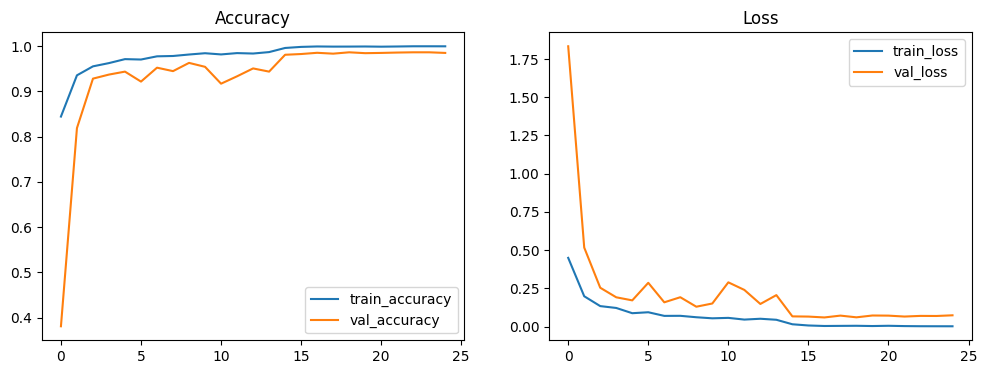

In [18]:
#model.save('ResNet50.h5')

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ResNet50.history['accuracy'], label='train_accuracy')
plt.plot(history_ResNet50.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ResNet50.history['loss'], label='train_loss')
plt.plot(history_ResNet50.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()